In [2]:
#import pip
## import seaborn
#pip.main(['install','seaborn'])

In [3]:
import numpy as np 
import pandas as pd 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import time
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import sklearn.externals
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## Model-based collaborative filtering system

In [4]:
file_one = 'merged.csv'
data = pd.read_csv(file_one) 
data.head()

,date,asin,user,rating,timestamp,ts_date
0,2-Oct-13,9875851809,A33YTN2JLRR53E,5.0,1.535587e+09,8/30/2018
1,4-Sep-73,B000068NXO,A2Q8TMZVWG7M8C,5.0,1.535155e+09,8/25/2018
2,4-Sep-73,B000068NXO,A2Q8TMZVWG7M8C,5.0,1.535155e+09,8/25/2018
3,13-Oct-17,1609319745,AHH7D9X7GMN53,5.0,1.534810e+09,8/21/2018
4,28-Nov-12,1309810397,A3CB1W1O9Z57VN,5.0,1.534378e+09,8/16/2018


In [5]:
df = data[['asin', 'user', 'rating']] 
df.head()

,asin,user,rating
0,9875851809,A33YTN2JLRR53E,5.0
1,B000068NXO,A2Q8TMZVWG7M8C,5.0
2,B000068NXO,A2Q8TMZVWG7M8C,5.0
3,1609319745,AHH7D9X7GMN53,5.0
4,1309810397,A3CB1W1O9Z57VN,5.0


In [6]:
#The dataset is a 1042868 x 3 matrix
df.shape

(1042868, 3)

In [7]:
df.dtypes

asin       object
user       object
rating    float64
dtype: object

In [8]:
# Look at Statistics of the rating variable
df.describe()['rating'].T

count    877951.000000
mean          4.177560
std           1.298668
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [9]:
#Find the min and max of rating
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [10]:
#Check for missing values
print('Number of missing values across columns: \n',df.isnull().sum())

Number of missing values across columns: 
 asin      164917
user      164917
rating    164917
dtype: int64


In [11]:
#
df1= df.dropna()
df1.head()

,asin,user,rating
0,9875851809,A33YTN2JLRR53E,5.0
1,B000068NXO,A2Q8TMZVWG7M8C,5.0
2,B000068NXO,A2Q8TMZVWG7M8C,5.0
3,1609319745,AHH7D9X7GMN53,5.0
4,1309810397,A3CB1W1O9Z57VN,5.0


In [12]:
#Check for missing values
print('Number of missing values across columns: \n',df1.isnull().sum())

Number of missing values across columns: 
 asin      0
user      0
rating    0
dtype: int64


In [13]:
print("Total data")
print("-"*50)
print("\nTotal no of ratings :",df1.shape[0])
print("Total No of Users   :", len(np.unique(df1.user)))
print("Total No of products  :", len(np.unique(df1.asin)))

Total data
--------------------------------------------------

Total no of ratings : 877951
Total No of Users   : 376533
Total No of products  : 16639


In [14]:
#Analysis of rating given by the user 
#Rank users by the number of ratings they made descending

rated_per_user = df1.groupby(by='user')['rating'].count().sort_values(ascending=False)

rated_per_user.head()

user
A2R6RA8FRBS608    73
A2AY4YUOX2N1BQ    72
A3OXHLG6DIBRW8    64
A203OCQQ12MAVT    64
AGXV8E7XK9J6H     62
Name: rating, dtype: int64

In [15]:
quantiles = rated_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [16]:
#Within rated products,find number of products have less than 10 ratings
print('\n No of rated product more than 20 per user : {}\n'.format(sum(rated_per_user >= 20)) )


 No of rated product more than 20 per user : 179



In [17]:
# new_df = df1.groupby("user").filter(lambda x:x['rating'].count() >=20)
# new_df.head(50)

In [18]:
#Create a user x product ID matrix

new_df = df1.head(5000)
ratings_matrix = new_df.pivot_table(values='rating', index='user', columns='asin', fill_value=0)
ratings_matrix.head(50)

asin,105997231X,106171327X,1309810397,1400501466,1400697492,1503716821,1609319745,161685572X,1933622326,1934931519,...,B0000AGATY,B0000AGAUT,B0000AHEHP,B0000AHO91,B0000AHO92,B0000AHO99,B0000AHZXK,B0000AI0N2,B0000AI1FR,B0000AI1HP
user,,,,,,,,,,,,,,,,,,,,,
A0455748DCIEXIHB3PIV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A09225229MO7JS8WEWGW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1028XZRNI0NRP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A102P6D3352JLV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A103BWSSSROFA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A104GZA57WRQU4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A106NDT51Z7TCN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1089L6OD3HW1F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A108NEP41RV059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#Total 2408 rows and 872 columns in the matrix
ratings_matrix.shape

(2408, 872)

In [20]:
# Transpose the previous matrix
X = ratings_matrix.T
X.head()

user,A0455748DCIEXIHB3PIV,A09225229MO7JS8WEWGW,A1028XZRNI0NRP,A102P6D3352JLV,A103BWSSSROFA,A104GZA57WRQU4,A106NDT51Z7TCN,A1089L6OD3HW1F,A108NEP41RV059,A108OD7EV20KAU,...,AZC7NNERBVMRN,AZE0KIKKJWB49,AZFMALF6H3TPH,AZG5BAZ7DZ6UA,AZIRYNX93E5XT,AZJWR2IABF58P,AZM3NKUMUJ66X,AZP80AOLJ4KR1,AZRE080M2B9TW,AZWMPLVQQ6QWP
asin,,,,,,,,,,,,,,,,,,,,,
105997231X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106171327X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1309810397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400697492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#We have 872 unique products, 2408 unique users who gave product ratings

X.shape

(872, 2408)

In [22]:
X1 = X

In [23]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(872, 10)

In [24]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(872, 872)

In [25]:
X.index[150]

'B00004TDA2'

In [26]:
i = "B00004TDA2"

product_id = list(X.index)
asin_id = product_id.index(i)
asin_id

150

In [27]:
correlation_asin_id = correlation_matrix[asin_id]
correlation_asin_id.shape

(872,)

In [28]:
Recommend = list(X.index[correlation_asin_id > 0.65])

# Removes the purchased item 
Recommend.remove(i) 

Recommend[0:10]

['9967222204',
 '9984101878',
 '998504780X',
 'B00000J1F3',
 'B00000J48J',
 'B00002N7FQ',
 'B00004TWLZ',
 'B00004Z5PN',
 'B00004ZC8P',
 'B00005133U']

## Popularity Based Recommendation

In [29]:
import matplotlib.pyplot as plt

In [30]:
#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=data.groupby("asin").filter(lambda x:x['rating'].count() >=50)

In [31]:
new_df.head()

,date,asin,user,rating,timestamp,ts_date
70,4-Sep-99,B00004YK4I,A1NPNHYYBU56F5,4.0,1.527034e+09,5/23/2018
71,4-Sep-99,B00004YK4I,A1NPNHYYBU56F5,4.0,1.527034e+09,5/23/2018
73,4-Sep-99,B00004YK4I,A1XIW68U4UUTYD,5.0,1.526947e+09,5/22/2018
74,4-Sep-99,B00004YK4I,A1XIW68U4UUTYD,5.0,1.526947e+09,5/22/2018
77,7-Jul-04,B000067SBX,A16VTLGFC51E0W,5.0,1.526861e+09,5/21/2018


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

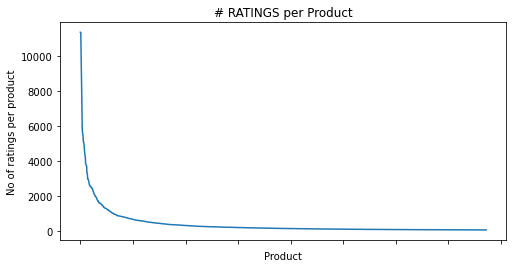

In [32]:
no_of_ratings_per_product = new_df.groupby(by='asin')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [33]:
#Average rating of the product
new_df.groupby('asin')['rating'].mean().head()

asin
059449771X    4.198473
101635370     2.910256
1059844575    2.468354
1060078031    3.873418
106171327X    4.436718
Name: rating, dtype: float64

In [34]:
new_df.groupby('asin')['rating'].mean().sort_values(ascending=False).head()

asin
B00008VSKS    5.000000
B00005BJEM    5.000000
B00000J0MS    4.997555
1630460001    4.983333
B0000AE6AK    4.960000
Name: rating, dtype: float64

In [35]:
#Total no of rating for product

new_df.groupby('asin')['rating'].count().sort_values(ascending=False).head()

asin
B00004ZCJJ    11390
B00004ZCJI    11390
B00009KLAE    11378
B00007M1TZ    10530
B00007E7JU     9324
Name: rating, dtype: int64

In [36]:
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['rating'].mean())

In [37]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['rating'].count())

In [38]:
ratings_mean_count.head()

,rating,rating_counts
asin,,
059449771X,4.198473,131
101635370,2.910256,78
1059844575,2.468354,237
1060078031,3.873418,158
106171327X,4.436718,719


In [39]:
top_avg_rating = ratings_mean_count.sort_values('rating', ascending= False)
# ratings_mean_count.head(30).plot(kind = "bar")
top_avg_rating.head(30)

,rating,rating_counts
asin,,
B00005BJEM,5.000000,72
B00008VSKS,5.000000,710
B00000J0MS,4.997555,818
1630460001,4.983333,60
B0000AE6AK,4.960000,50
B00009XVL7,4.948718,156
B000084EJJ,4.942857,70
B000053HC5,4.930693,606
B00009XVL0,4.923077,182


In [40]:
#Max number of ratings for a product
ratings_mean_count['rating_counts'].max()

11390

<Figure size 576x432 with 0 Axes>

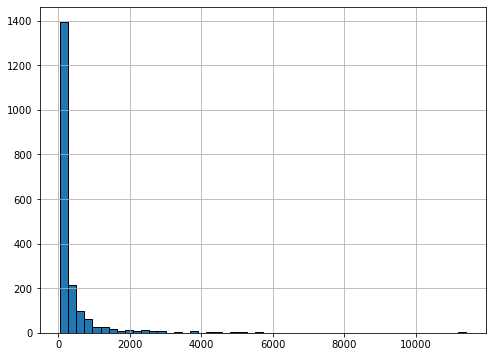

In [41]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

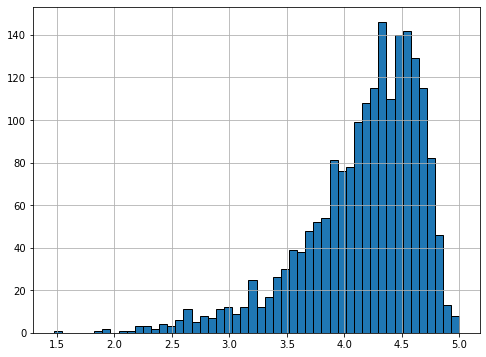

In [42]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

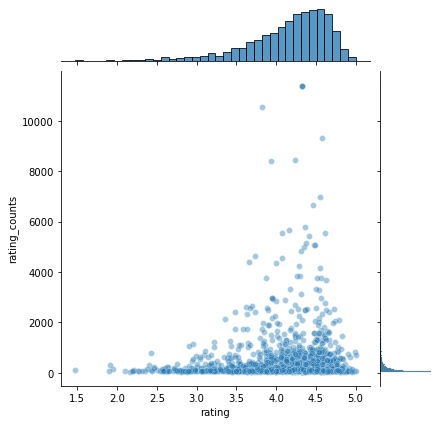

In [43]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

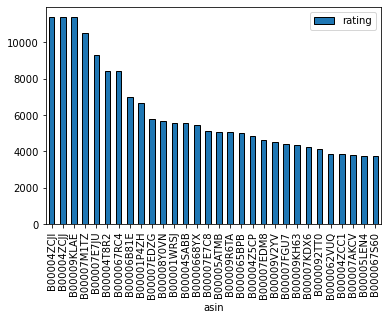

In [45]:
popular_products = pd.DataFrame(new_df.groupby('asin')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")